# Fast Gradient Sign Method for generating adversarial examples

In [6]:
import numpy as np
from keras.applications import vgg16
from keras.preprocessing import image
from keras.activations import relu, softmax
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [7]:
# Load VGG-16 model pretrained on ImageNet dataset
model = vgg16.VGG16(weights='imagenet')

W0726 03:04:11.470108 140381631133568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 03:04:11.514715 140381631133568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 03:04:11.524244 140381631133568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0726 03:04:11.564858 140381631133568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 28s 0us/step


W0726 03:04:40.858691 140381631133568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0726 03:04:40.859694 140381631133568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [8]:
!wget https://raw.githubusercontent.com/soumyac1999/FGSM-Keras/master/orange.jpg

--2019-07-26 03:04:46--  https://raw.githubusercontent.com/soumyac1999/FGSM-Keras/master/orange.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 204426 (200K) [image/jpeg]
Saving to: ‘orange.jpg.1’

orange.jpg.1        100%[===================>] 199.63K  --.-KB/s    in 0.03s   

2019-07-26 03:04:46 (5.83 MB/s) - ‘orange.jpg.1’ saved [204426/204426]



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


40960/35363 [==================================] - 0s 0us/step
Predicted: [('n07747607', 'orange', 0.9942145), ('n07749582', 'lemon', 0.0041732057), ('n03991062', 'pot', 0.00032574168)]


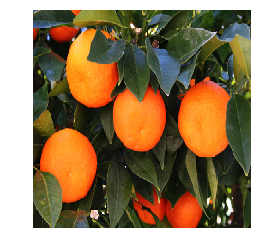

In [9]:
img_path = '/content/orange.jpg'
img = image.load_img(img_path, target_size=(224,224))

plt.imshow(img)
plt.grid('off')
plt.axis('off')

# Create a batch and preprocess the image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = vgg16.preprocess_input(x)

# Get the initial predictions
preds = model.predict(x)
initial_class = np.argmax(preds)
print('Predicted:', vgg16.decode_predictions(preds, top=3)[0])

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


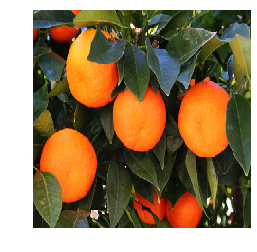

In [10]:
# Inverse of the preprocessing and plot the image
def plot_img(x):
    """
    x is a BGR image with shape (? ,224, 224, 3) 
    """
    t = np.zeros_like(x[0])
    t[:,:,0] = x[0][:,:,2]
    t[:,:,1] = x[0][:,:,1]
    t[:,:,2] = x[0][:,:,0]  
    plt.imshow(np.clip((t+[123.68, 116.779, 103.939]), 0, 255)/255)
    plt.grid('off')
    plt.axis('off')
    plt.show()

# Sanity Check
plot_img(x)

In [0]:
# Get current session (assuming tf backend)
sess = K.get_session()
# Initialize adversarial example with input image
x_adv = x
# Added noise
x_noise = np.zeros_like(x)

W0726 03:06:30.879775 140381631133568 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0 4.3977794e-05 [('n07747607', 'orange', 0.9937941), ('n07749582', 'lemon', 0.0044014845), ('n03991062', 'pot', 0.00035904776)]
20 0.00082135556 [('n07747607', 'orange', 0.974281), ('n07749582', 'lemon', 0.011465239), ('n03991062', 'pot', 0.0020506894)]
40 0.008291386 [('n07747607', 'orange', 0.9012806), ('n07749582', 'lemon', 0.024245251), ('n07718472', 'cucumber', 0.008291386)]
60 0.041148126 [('n07747607', 'orange', 0.7199671), ('n07718472', 'cucumber', 0.041148126), ('n07749582', 'lemon', 0.0356232)]
80 0.1031668 [('n07747607', 'orange', 0.46678492), ('n07718472', 'cucumber', 0.1031668), ('n07749582', 'lemon', 0.03712275)]
100 0.16540012 [('n07747607', 'orange', 0.2724715), ('n07718472', 'cucumber', 0.16540012), ('n07717410', 'acorn_squash', 0.049008284)]
120 0.21704674 [('n07718472', 'cucumber', 0.21704674), ('n07747607', 'orange', 0.16115674), ('n07717410', 'acorn_squash', 0.06048261)]
140 0.25507095 [('n07718472', 'cucumber', 0.25507095), ('n07747607', 'orange', 0.10305099), ('n

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


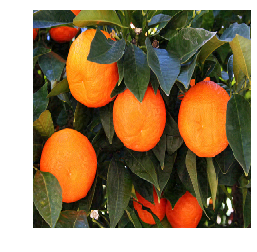

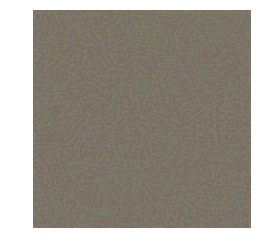

In [12]:
# Set variables
epochs = 400
epsilon = 0.01
target_class = 943 # cucumber
prev_probs = []

for i in range(epochs): 
    # One hot encode the target class
    target = K.one_hot(target_class, 1000)
    
    # Get the loss and gradient of the loss wrt the inputs
    loss = -1*K.categorical_crossentropy(target, model.output)
    grads = K.gradients(loss, model.input)

    # Get the sign of the gradient
    delta = K.sign(grads[0])
    x_noise = x_noise + delta

    # Perturb the image
    x_adv = x_adv + epsilon*delta

    # Get the new image and predictions
    x_adv = sess.run(x_adv, feed_dict={model.input:x})
    preds = model.predict(x_adv)

    # Store the probability of the target class
    prev_probs.append(preds[0][target_class])

    if i%20==0:
        print(i, preds[0][target_class], vgg16.decode_predictions(preds, top=3)[0])

plot_img(x_adv)
plot_img(x_adv-x)